In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import keras.layers as layers
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import confusion_matrix

/tmp/ipykernel_576521/763609900.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-07 16:17:39.355007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 16:17:39.355036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 16:17:39.356073: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable 

In [2]:
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [3]:
def map_to_class(value):
    class_to_number
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)

In [4]:
def read_images_dataframe(dataframe):
    images = []
    for image_path in dataframe['image_filepath']:
        img = cv2.imread("InfraredSolarModules/"+image_path,cv2.IMREAD_GRAYSCALE)
        img = img.reshape(40, 24).astype("float32") / 255
        images.append(img)
    images=np.array(images) 
    return images

def read_labels_dataframe(dataframe):
    labels = []
    for label in dataframe['class_code']:
        labels.append(label)
    labels=np.array(labels) 
    labels.astype("int32")   
    return labels

In [5]:
images = read_images_dataframe(DataSolarModules)
labels = read_labels_dataframe(DataSolarModules)

In [6]:
inputs = keras.Input(shape=(40, 24, 1))


x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)

x = layers.Dense(2048, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(128, activation="relu")(x)


outputs = layers.Dense(12, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 24, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 38, 22, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 11, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 9, 32)         4640      
                                                                 


2024-02-07 16:17:43.862823: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 16:17:43.885347: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 16:17:43.885541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

 max_pooling2d_1 (MaxPoolin  (None, 8, 4, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 2, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 2048)              1574912   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (

In [7]:
batch_size = 64
n_epochs = 25

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

rkf = RepeatedKFold(n_splits=6, n_repeats=3, random_state=21312312)
datos = list(range(0,len(DataSolarModules)))

data_train, data_test = train_test_split(datos, test_size=0.2)


model.compile(optimizer=optimizer,                                    
              loss="sparse_categorical_crossentropy",                 
              metrics=["accuracy"])   


fold_no = 1
acc_per_fold = []
loss_per_fold = []

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

In [8]:
for train, test in rkf.split(data_train):
    

    history_model = model.fit(images[train], labels[train],
                              epochs=n_epochs,
                              validation_data=(images[test], labels[test]),
                              batch_size=batch_size,
                              verbose=0)


    # Store metrics for this fold
    fold_train_loss = np.mean(history_model.history['loss'])
    fold_train_accuracy = np.mean(history_model.history['accuracy'])
    fold_val_loss = np.mean(history_model.history['val_loss'])
    fold_val_accuracy = np.mean(history_model.history['val_accuracy'])

    all_train_losses.append(fold_train_loss)
    all_train_accuracies.append(fold_train_accuracy)
    all_val_losses.append(fold_val_loss)
    all_val_accuracies.append(fold_val_accuracy)


    # Generate generalization metrics for the last epoch
    scores = model.evaluate(images[data_test], labels[data_test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

2024-02-07 16:17:44.991659: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-02-07 16:17:45.747080: I external/local_xla/xla/service/service.cc:168] XLA service 0x560c0298ab30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-07 16:17:45.747097: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-02-07 16:17:45.751618: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707333465.827384  577445 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Score for fold 1: loss of 0.6291470527648926; accuracy of 80.54999709129333%
Score for fold 2: loss of 0.3228035569190979; accuracy of 89.52500224113464%
Score for fold 3: loss of 0.21559953689575195; accuracy of 93.69999766349792%
Score for fold 4: loss of 0.15534216165542603; accuracy of 95.47500014305115%
Score for fold 5: loss of 0.10885482281446457; accuracy of 96.95000052452087%
Score for fold 6: loss of 0.11257737129926682; accuracy of 97.2249984741211%
Score for fold 7: loss of 0.08300921320915222; accuracy of 98.17500114440918%
Score for fold 8: loss of 0.06476013362407684; accuracy of 98.17500114440918%
Score for fold 9: loss of 0.07761478424072266; accuracy of 97.97499775886536%
Score for fold 10: loss of 0.06454645842313766; accuracy of 98.1249988079071%
Score for fold 11: loss of 0.06787198781967163; accuracy of 98.35000038146973%
Score for fold 12: loss of 0.06162915378808975; accuracy of 98.4250009059906%
Score for fold 13: loss of 0.06059800833463669; accuracy of 98.600

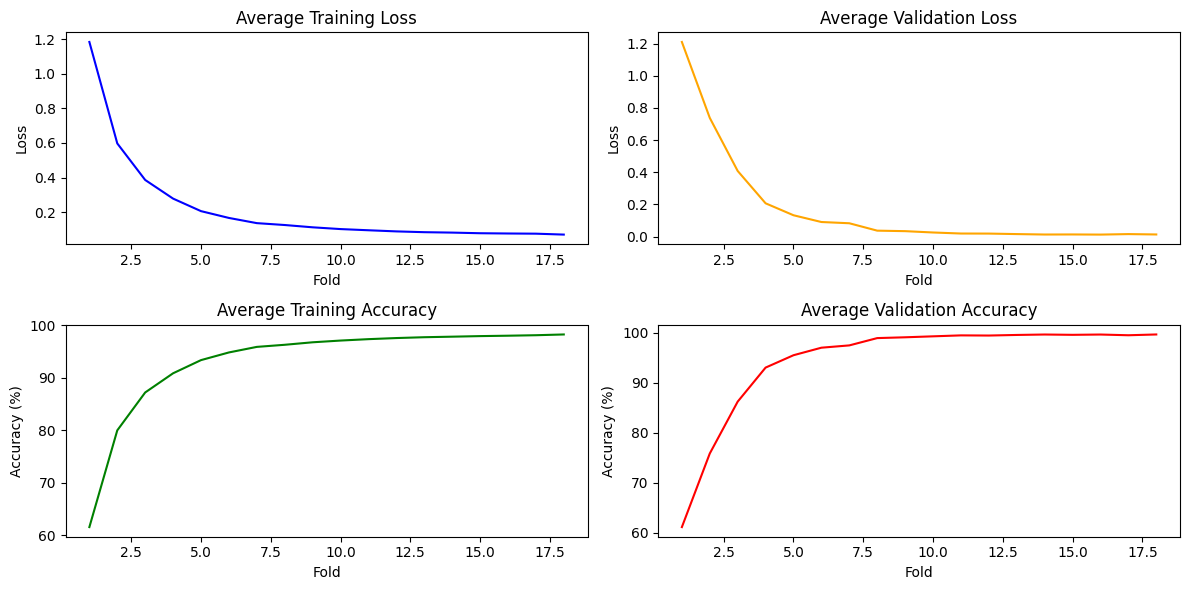

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, color='blue')
plt.title('Average Training Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, color='orange')
plt.title('Average Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(range(1, len(all_train_accuracies) + 1), [acc * 100 for acc in all_train_accuracies], color='green')
plt.title('Average Training Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')

plt.subplot(2, 2, 4)
plt.plot(range(1, len(all_val_accuracies) + 1), [acc * 100 for acc in all_val_accuracies], color='red')
plt.title('Average Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

In [12]:
test_metrics = model.evaluate(images[data_test], labels[data_test])  
print("Test loss:", test_metrics[0])
print("Test accuracy:", test_metrics[1])

125/125 [==============================] - 0s 1ms/step - loss: 0.0698 - accuracy: 0.9860
Test loss: 0.0698108971118927
Test accuracy: 0.9860000014305115


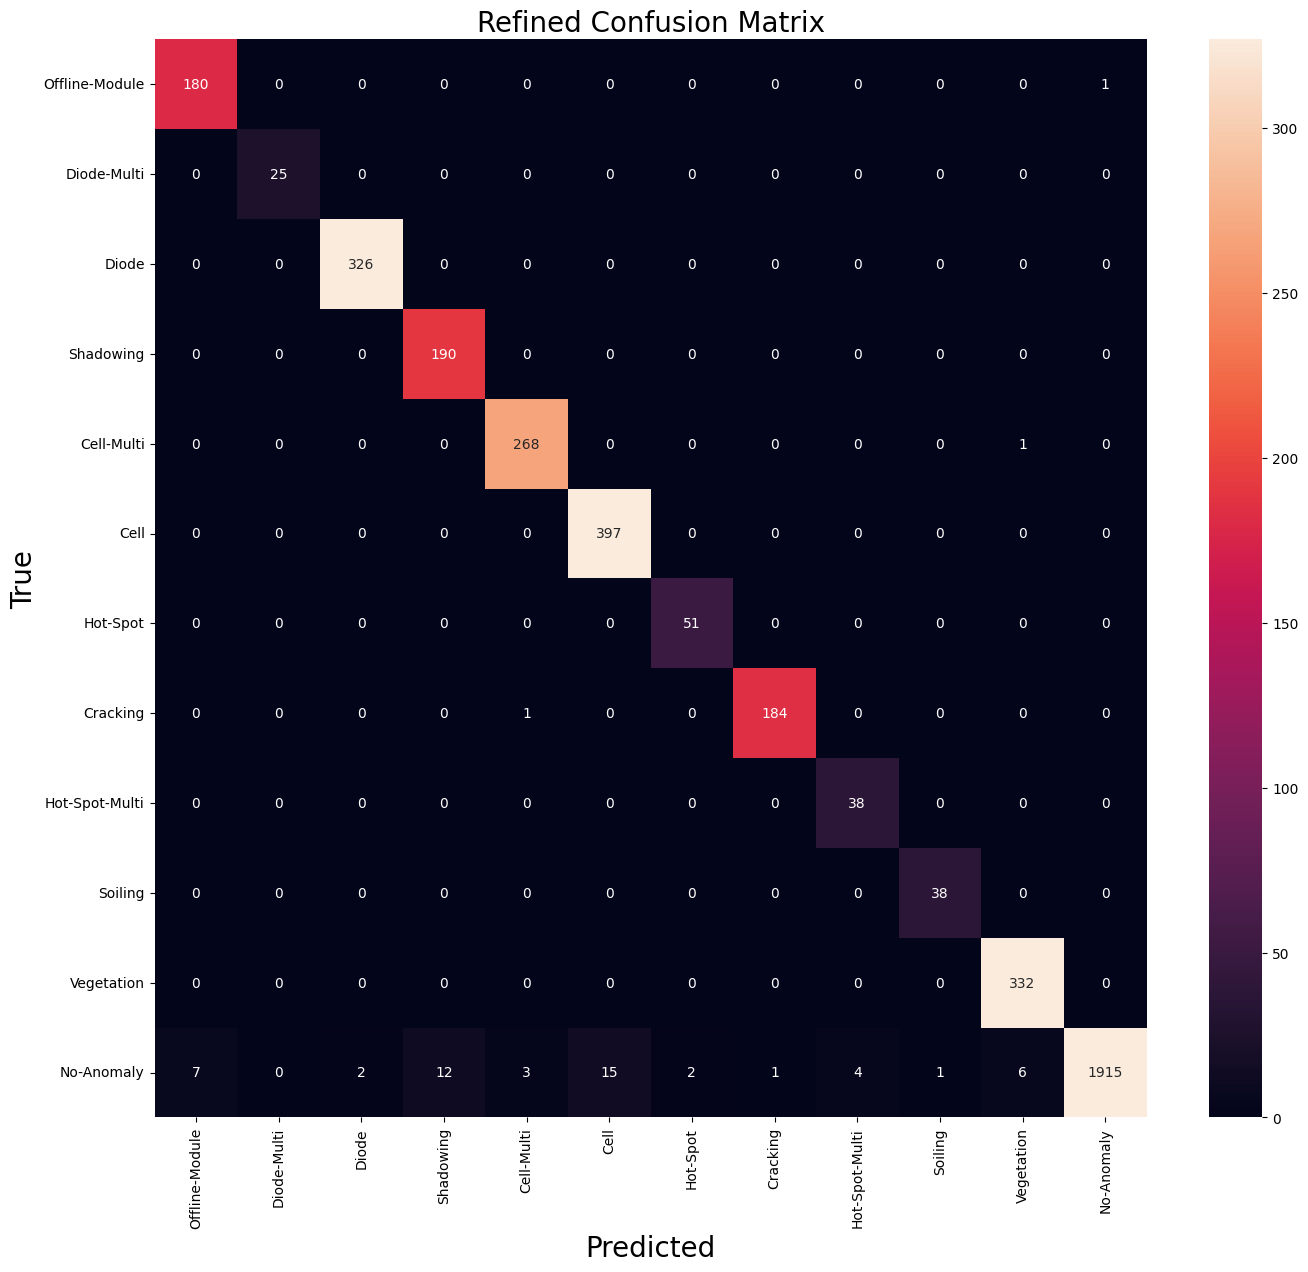

In [13]:
### Confusion Matrix
predictions = model.predict(images[data_test], steps=len(data_test), verbose=0)

y_pred = np.argmax(predictions, axis=-1)

cm = confusion_matrix(labels[data_test], y_pred)

## Get Class Labels
class_names = Classes

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True,robust=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

In [14]:
tp_and_fn = cm.sum(1)
tp_and_fp = cm.sum(0)
tp = cm.diagonal()
accuracy = cm.diagonal().sum()/cm.sum()
precision = tp / tp_and_fp
recall = tp / tp_and_fn
f1 = 2 * (precision * recall) / (precision + recall)
precision_avg=np.average(precision)
recall_avg=np.average(recall)
f1_avg=np.average(f1)

In [15]:
# Creating a dictionary with the data
data = {
    'Metrics': ['Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score'],
    'Values': [accuracy, precision_avg, recall_avg, f1_avg]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Metrics    Values
0           Accuracy  0.986000
1  Average Precision  0.971730
2     Average Recall  0.996535
3   Average F1 Score  0.983737


In [16]:
data = {
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Class  Precision    Recall  F1 Score
0   Offline-Module   0.962567  0.994475  0.978261
1      Diode-Multi   1.000000  1.000000  1.000000
2            Diode   0.993902  1.000000  0.996942
3        Shadowing   0.940594  1.000000  0.969388
4       Cell-Multi   0.985294  0.996283  0.990758
5             Cell   0.963592  1.000000  0.981459
6         Hot-Spot   0.962264  1.000000  0.980769
7         Cracking   0.994595  0.994595  0.994595
8   Hot-Spot-Multi   0.904762  1.000000  0.950000
9          Soiling   0.974359  1.000000  0.987013
10      Vegetation   0.979351  1.000000  0.989568
11      No-Anomaly   0.999478  0.973069  0.986097
